## GMLS-Nets: 1D Regression of Linear and Non-linear Operators $L[u]$.

__Ben J. Gross__, __Paul J. Atzberger__ <br>
http://atzberger.org/

Examples showing how GMLS-Nets can be used to perform regression for some basic linear and non-linear differential operators in 1D.  

__Parameters:__</span> <br>
The key parameter terms to adjust are:<br> 
``op_type``: The operator type.<br>
``flag_mlp_case``: The type of mapping unit to use.<br>

__Examples of Non-linear Operators ($u{u_x},u_x^2,u{u_{xx}},u_{xx}^2$) :__<br>
To run training for a non-linear operator like ``u*ux`` using MLP for the non-linear GMLS mapping unit, you can use:<br> 
``op_type='u*ux';`` <br>
``flag_mlp_case = 'NonLinear1';`` <br>
You can obtain different performance by adjusting the mapping architecture and hyperparameters of the network.

__Examples of linear Operators ($u_x,u_{xx}$):__<br>
To run training for a linear operator like the 1d Laplacian ``uxx`` with a linear mapping unit, you can use<br> 
``op_type='uxx';``<br>
``flag_mlp_case = 'Linear1';``<br>

These are organized for different combinations of these settings allowing for exploring the methods.  The codes are easy to modify and adjust to also experiment with other operators.  For example, see the dataset classes.


### Imports

In [1]:
import sys;

# setup path to location of gmlsnets_pytorch (if not install system-wide)
path_gmlsnets_pytorch = '../../';
sys.path.append(path_gmlsnets_pytorch);

import torch;
import torch.nn as nn;

import numpy as np;
import pickle;

import matplotlib.pyplot as plt;

import pdb
import time

import os

# setup gmlsnets package
import gmlsnets_pytorch as gmlsnets;
import gmlsnets_pytorch.nn;
import gmlsnets_pytorch.vis;
import gmlsnets_pytorch.dataset;

# dereference a few common items
MapToPoly_Function = gmlsnets.nn.MapToPoly_Function;
get_num_polys = MapToPoly_Function.get_num_polys;
weight_one_minus_r = MapToPoly_Function.weight_one_minus_r;
eval_poly = MapToPoly_Function.eval_poly;

print("Packages:");
print("torch.__version__ = " + str(torch.__version__));
print("numpy.__version__ = " + str(np.__version__));
print("gmlsnets.__version__ = " + str(gmlsnets.__version__));

Packages:
torch.__version__ = 1.2.0
numpy.__version__ = 1.16.4
gmlsnets.__version__ = 1.0.0


### Parameters and basic setup

In [2]:
# Setup the parameters
batch_size = int(1e2);
flag_extend_periodic = False; # periodic boundaries
flag_dataset = 'diffOp1';
run_name = '%s_Test1'%flag_dataset;
base_dir = './output/regression_diff_op_1d/%s'%run_name;
flag_print_model = False;

print("Settings:");
print("flag_dataset = " + flag_dataset);
print("run_name = " + run_name);
print("base_dir = " + base_dir);  

if not os.path.exists(base_dir):
  os.makedirs(base_dir);

# Configure devices
if torch.cuda.is_available():  
  num_gpus = torch.cuda.device_count();
  print("num_gpus = " + str(num_gpus));
  if num_gpus >= 4:
    device = torch.device('cuda:3');
  else:
    device = torch.device('cuda:0');
else: 
  device = torch.device('cpu');
print("device = " + str(device));           


Settings:
flag_dataset = diffOp1
run_name = diffOp1_Test1
base_dir = ./output/regression_diff_op_1d/diffOp1_Test1
num_gpus = 4
device = cuda:3


### Setup GMLS-Net for regressing differential operator

In [3]:
class gmlsNetRegressionDiffOp1(nn.Module):
    """Sets up a GMLS-Net for regression differential operator in 1D."""    

    def __init__(self,
                 flag_GMLS_type=None, 
                 porder1=None,Nc=None,
                 pts_x1=None,layer1_epsilon=None, 
                 weight_func1=None,weight_func1_params=None, 
                 mlp_q1=None,pts_x2=None,
                 device=None,flag_verbose=0,
                 **extra_params):

        super(gmlsNetRegressionDiffOp1, self).__init__();

        self.layer_types = [];

        if device is None:
          device = torch.device('cpu');  # default 

        # --
        Ncp1 = mlp_q1.channels_out; # number of channels out of the MLP-Pointwise layer

        num_features1 = mlp_q1.channels_out;  # number of channels out (16 typical)

        GMLS_Layer = gmlsnets.nn.GMLS_Layer;
        ExtractFromTuple = gmlsnets.nn.ExtractFromTuple;
        PermuteLayer = gmlsnets.nn.PermuteLayer;        
        PdbSetTraceLayer = gmlsnets.nn.PdbSetTraceLayer;

        # --- Layer 1
        #flag_layer1 = 'standard_conv1';
        flag_layer1 = 'gmls1d_1';
        self.layer_types.append(flag_layer1);
        if flag_layer1 == 'standard_conv1':
          self.layer1 = nn.Sequential(
               nn.Conv1d(in_channels=Nc,out_channels=num_features1,
                         kernel_size=5,stride=1,padding=2,bias=False),               
               ).to(device);
        elif flag_layer1 == 'gmls1d_1':
          self.layer1 = nn.Sequential(               
               GMLS_Layer(flag_GMLS_type, porder1, 
                          pts_x1, layer1_epsilon, 
                          weight_func1, weight_func1_params, 
                          mlp_q=mlp_q1, pts_x2=pts_x2, device=device, 
                          flag_verbose=flag_verbose),    
               #PdbSetTraceLayer(),
               ExtractFromTuple(index=0), # just get the forward output associated with the mapping and not pts_x2           
               #PdbSetTraceLayer(),
               PermuteLayer((0,2,1))
               ).to(device);

        else:
          raise Exception('flag_layer1 type not recognized.');
        
    def forward(self, x):        
        out = self.layer1(x);
        return out;


### Setup the Model: Neural Network

In [4]:
# setup sample point locations
xj = torch.linspace(0,1.0,steps=101,device=device).unsqueeze(1);
xi = torch.linspace(0,1.0,steps=101,device=device).unsqueeze(1);

# make a numpy copy for plotting and some other routines
np_xj = xj.cpu().numpy(); np_xi = xi.cpu().numpy();

# setup parameters
Nc = 1; # scalar field
Nx = xj.shape[0]; num_dim = xj.shape[1];
porder = 2; num_polys = get_num_polys(porder,num_dim);

weight_func1 = MapToPoly_Function.weight_one_minus_r;
targ_kernel_width = 11.5; layer1_epsilon = 0.4*0.5*np.sqrt(2)*targ_kernel_width/Nx; 
#targ_kernel_width = 21.5; layer1_epsilon = 0.4*0.5*np.sqrt(2)*targ_kernel_width/Nx; 
weight_func1_params = {'epsilon': layer1_epsilon,'p':4};

color_input = (0.05,0.44,0.69);
color_output = (0.44,0.30,0.60);
color_predict = (0.05,0.40,0.5);
color_target = (221/255,103/255,103/255);

# print the current settings
print("GMLS Parameters:")
print("porder = " + str(porder));
print("num_dim = " + str(num_dim));
print("num_polys = " + str(num_polys));
print("layer1_epsilon = %.3e"%layer1_epsilon);
print("weight_func1 = " + str(weight_func1));
print("weight_func1_params = " + str(weight_func1_params));
print("xj.shape = " + str(xj.shape));
print("xi.shape = " + str(xi.shape));

GMLS Parameters:
porder = 2
num_dim = 1
num_polys = 3
layer1_epsilon = 3.220e-02
weight_func1 = <function MapToPoly_Function.weight_one_minus_r at 0x7fe5b0bc2290>
weight_func1_params = {'epsilon': 0.03220486330156554, 'p': 4}
xj.shape = torch.Size([101, 1])
xi.shape = torch.Size([101, 1])


In [5]:
# create an MLP for training the non-linear part of the GMLS Net
#flag_mlp_case = 'Linear1';flag_mlp_case = 'Nonlinear1'
flag_mlp_case = 'Nonlinear1';
if (flag_mlp_case == 'Linear1'):
  layer_sizes  = [];

  num_depth    = 0;  # number of internal layers
  num_hidden   = -1; # number of hidden per layer

  channels_in  = Nc; # number of poly channels (matches input u channel size)
  channels_out = 1;  # number of output filters
  
  layer_sizes.append(num_polys); # input
  layer_sizes.append(1); # output, single channel always, for vectors, we use channels_out separate units.

  mlp_q1 = gmlsnets.nn.MLP_Pointwise(layer_sizes,channels_in=channels_in,channels_out=channels_out,
                                     flag_bias=False).to(device);
elif (flag_mlp_case == 'Nonlinear1'):
  layer_sizes = [];
  num_input   = Nc*num_polys; # number of channels*num_polys, allows for cross-channel coupling
  num_depth   = 4; # number of internal layers
  num_hidden  = 100; # number of hidden per layer
  num_out_channels = 16; # number of output filters
  layer_sizes.append(num_polys);
  for k in range(num_depth):
    layer_sizes.append(num_hidden);
  layer_sizes.append(1); # output, single channel always, for vectors, we use channels_out separate units.
    
  mlp_q1 = gmlsnets.nn.MLP_Pointwise(layer_sizes,channels_out=num_out_channels,
                                     flag_bias=True).to(device);
  
if flag_print_model:
  print("mlp_q1:");
  print(mlp_q1);

In [6]:
# Setup the Neural Network for Regression
flag_verbose = 0;
flag_case = 'standard';

# Setup the model
xi = xi.float();
xj = xj.float();
model = gmlsNetRegressionDiffOp1(flag_case,porder,Nc,xj,layer1_epsilon,
                                 weight_func1,weight_func1_params,
                                 mlp_q1=mlp_q1,pts_x2=xi,
                                 device=device, 
                                 flag_verbose=flag_verbose);

if flag_print_model:
  print("model:");
  print(model);

## Setup the training and test data

In [7]:
### Generate Dataset

if flag_dataset == 'diffOp1':
  # Use the FFT to represent differential operators for training data sets.
  #
  # Setup a data set of the following:
  # To start let's do regression for the Laplacian (not inverse, just action of it, like finding FD)
  #

  #op_type = 'u*ux';op_type = 'ux*ux';op_type = 'uxx';op_type = 'u*uxx';op_type = 'uxx*uxx';
  op_type = 'u*ux';
  flag_verbose = 1;

  num_training_samples = int(5e4);
  nchannels = 1;
  nx = np_xj.shape[0];
  #alpha1 = 0.05;
  alpha1 = 0.1;
  scale_factor = 1e2;
  train_dataset = gmlsnets.dataset.diffOp1(op_type=op_type,op_params=None,
                                           gen_mode='exp1',gen_params={'alpha1':alpha1},
                                           num_samples=num_training_samples,
                                           nchannels=nchannels,nx=nx,
                                           noise_factor=0,scale_factor=scale_factor,
                                           flag_verbose=flag_verbose);
  
  train_dataset = train_dataset.to(device);
  if flag_verbose > 0:
    print("done.");

  num_test_samples = int(1e4);
  scale_factor = 1e2;
  test_dataset = gmlsnets.dataset.diffOp1(op_type=op_type,op_params=None,
                                          gen_mode='exp1',gen_params={'alpha1':alpha1},
                                          num_samples=num_test_samples,
                                          nchannels=nchannels,nx=nx,
                                          noise_factor=0,scale_factor=scale_factor,
                                          flag_verbose=flag_verbose);
  test_dataset = test_dataset.to(device);
    
  if flag_verbose > 0:
    print("done.");

  # Put the data into the 
  #train_dataset and test_dataset structures for processing

else:
  msg = "flag_dataset not recognized.";
  msg += "flag_data_set = " + str(flag_data_set);
  raise Exception(msg);

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True);
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False);



Generating the data samples which can take some time.
num_samples = 50000
done.
Generating the data samples which can take some time.
num_samples = 10000
done.


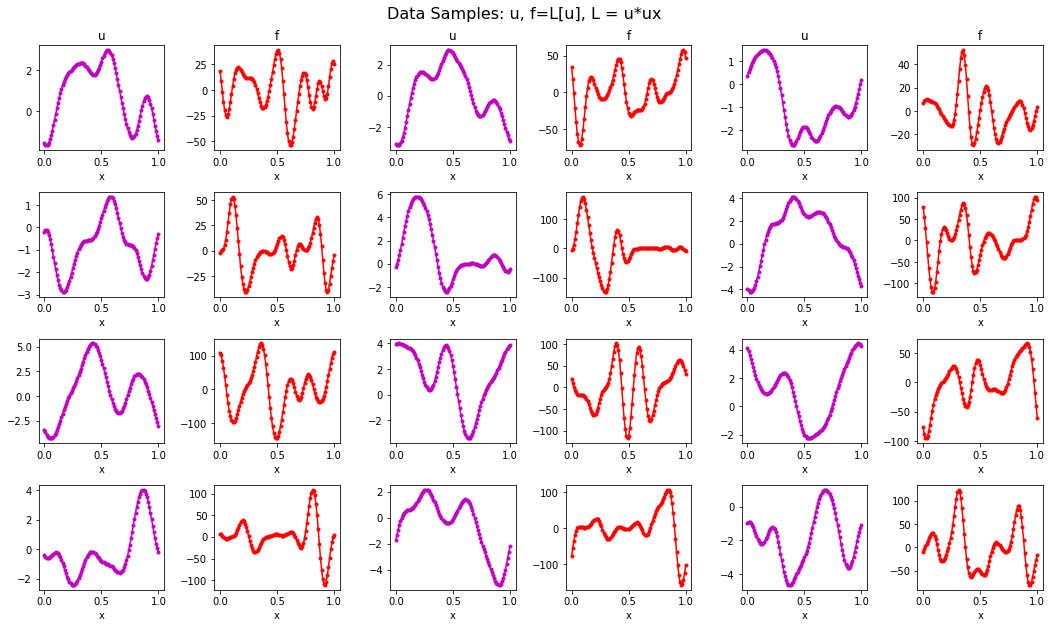

In [8]:
%matplotlib inline

# plot sample of the training data
gmlsnets.vis.plot_dataset_diffOp1(train_dataset,np_xj,np_xi,rows=4,cols=6,
                                  title="Data Samples: u, f=L[u], L = %s"%op_type);

## Train the Model

### Custom Functions

In [9]:
def custom_loss_least_squares(val1,val2):  
  r"""Computes the Mean-Square-Error (MSE) over the entire batch."""
  diff_flat = (val1 - val2).flatten();
  N = diff_flat.shape[0];
  loss = torch.sum(torch.pow(diff_flat,2),-1)/N;
  return loss;

def domain_periodic_repeat(Z):
  r"""Extends the input periodically."""  
  Z_periodic = torch.cat((Z, Z, Z), 2);
  return Z_periodic;
        
def domain_periodic_extract(Z_periodic):
  r"""Extracts the middle unit cell portion of the extended data."""  
  nn = int(Z_periodic.shape[2]/3);
  Z = Z_periodic[:,:,nn:2*nn];
  return Z;

### Initialize

In [10]:
loss_list = np.empty(0); loss_step_list = np.empty(0);
save_skip = 1; step_count = 0;

### Train the network.

In [11]:
num_epochs    = int(3e0); #int(1e4);
learning_rate = 1e-2;

print("Training the network with:");
print("");
print("model:");
print("model.layer_types = " + str(model.layer_types));
print("");

# setup the optimization method and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);

#loss_func = nn.CrossEntropyLoss();
#loss_func = nn.MSELoss();
loss_func = custom_loss_least_squares;

print("num_epochs = %d"%num_epochs);
print("batch_size = %d"%batch_size);
print(" ");

# Train the model
flag_time_it = True;
if flag_time_it:
  time_1 = time.time();
print("-"*80);
num_steps = len(train_loader);
for epoch in range(num_epochs):
    for i, (input,target) in enumerate(train_loader):         
        input  = input.to(device);
        target = target.to(device);
        
        if flag_extend_periodic:
          # Extend input periodically
          input_periodic = domain_periodic_repeat(input);

          # Forward pass
          output_periodic = model(input_periodic);
          output = domain_periodic_extract(output_periodic);
        else:
          output = model(input);

        # Compute loss
        loss = loss_func(output,target);

        # Display
        if step_count % save_skip == 0:
          np_loss   = loss.cpu().detach().numpy();
          loss_list = np.append(loss_list,np_loss);
          loss_step_list = np.append(loss_step_list,step_count);
        
        # Back-propagation for gradients and use to optimize
        optimizer.zero_grad();                
        loss.backward();
                
        optimizer.step();
        
        step_count += 1;
        
        if ((i + 1) % 100) == 0 or i == 0:        
          msg = 'epoch: [%d/%d]; '%(epoch+1,num_epochs);
          msg += 'batch_step = [%d/%d]; '%(i + 1,num_steps);
          msg += 'loss_MSE: %.3e.'%(loss.item());
          print(msg);
            
          if flag_time_it and i > 0:
            msg = 'elapsed_time = %.4e secs \n'%(time.time() - time_1);            
            print(msg);
            time_1 = time.time();

            
print("done training.")
print("-"*80);

Training the network with:

model:
model.layer_types = ['gmls1d_1']

num_epochs = 3
batch_size = 100
 
--------------------------------------------------------------------------------
epoch: [1/3]; batch_step = [1/500]; loss_MSE: 1.642e+03.
epoch: [1/3]; batch_step = [100/500]; loss_MSE: 2.088e+02.
elapsed_time = 4.1750e+00 secs 

epoch: [1/3]; batch_step = [200/500]; loss_MSE: 1.286e+02.
elapsed_time = 4.2026e+00 secs 

epoch: [1/3]; batch_step = [300/500]; loss_MSE: 6.603e+01.
elapsed_time = 4.4263e+00 secs 

epoch: [1/3]; batch_step = [400/500]; loss_MSE: 7.932e+01.
elapsed_time = 4.4641e+00 secs 

epoch: [1/3]; batch_step = [500/500]; loss_MSE: 2.718e+01.
elapsed_time = 4.4179e+00 secs 

epoch: [2/3]; batch_step = [1/500]; loss_MSE: 2.126e+01.
epoch: [2/3]; batch_step = [100/500]; loss_MSE: 9.035e+00.
elapsed_time = 4.6116e+00 secs 

epoch: [2/3]; batch_step = [200/500]; loss_MSE: 8.711e+00.
elapsed_time = 5.0313e+00 secs 

epoch: [2/3]; batch_step = [300/500]; loss_MSE: 8.170e+00.

### Plot Loss

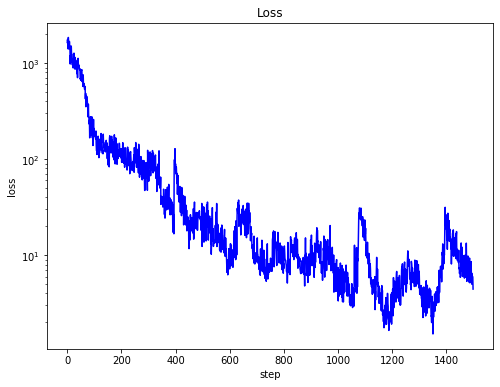

In [12]:
%matplotlib inline

plt.figure(figsize=(8,6));

plt.plot(loss_step_list,loss_list,'b-');
plt.yscale('log');
plt.xlabel('step');
plt.ylabel('loss');

plt.title('Loss');

### Test the Neural Network Predictions 

In [13]:
print("Testing predictions of the neural network:");

flag_save_tests = True;
if flag_save_tests:
  test_data = {};

# Save the first few to show as examples of labeling
saved_test_input = [];
saved_test_target = [];
saved_test_output_pred = [];

count_batch = 0;
with torch.no_grad():    
    total = 0; II = 0;
    avg_error = 0;
    for input,target in test_loader: # loads data in batches and then sums up

        if (II >= 1000):
          print("tested on %d samples"%total);
          II = 0;

        input = input.to(device); target = target.to(device);        
        
        # Compute model
        flag_extend_periodic = False;
        if flag_extend_periodic:
          # Extend input periodically
          input_periodic = domain_periodic_repeat(input);

          # Forward pass
          output_periodic = model(input_periodic);
          output = domain_periodic_extract(output_periodic);
        else:
          output = model(input);        

        # Compute loss
        loss = loss_func(output,target);

        # Record the results
        avg_error += loss;       

        total += output.shape[0];        
        II += output.shape[0];
        count_batch += 1;

    NN = output.shape[0];
    for k in range(min(NN,20)): # save first 10 images of each batch          
      saved_test_input.append(input[k]); 
      saved_test_target.append(target[k]);
      saved_test_output_pred.append(output[k]);
        
    print("");
    print("Tested on a total of %d samples."%total);    
    print("");
    
    # Compute RMSD error
    test_accuracy = avg_error.cpu()/count_batch;
    test_accuracy = np.sqrt(test_accuracy); 

    print("The neural network has RMSD error %.2e on the %d test samples."%(test_accuracy,total));    
    print("");


Testing predictions of the neural network:
tested on 1000 samples
tested on 2000 samples
tested on 3000 samples
tested on 4000 samples
tested on 5000 samples
tested on 6000 samples
tested on 7000 samples
tested on 8000 samples
tested on 9000 samples

Tested on a total of 10000 samples.

The neural network has RMSD error 2.38e+00 on the 10000 test samples.



### Show a Sample of the Predictions 

num_prediction_samples = 20


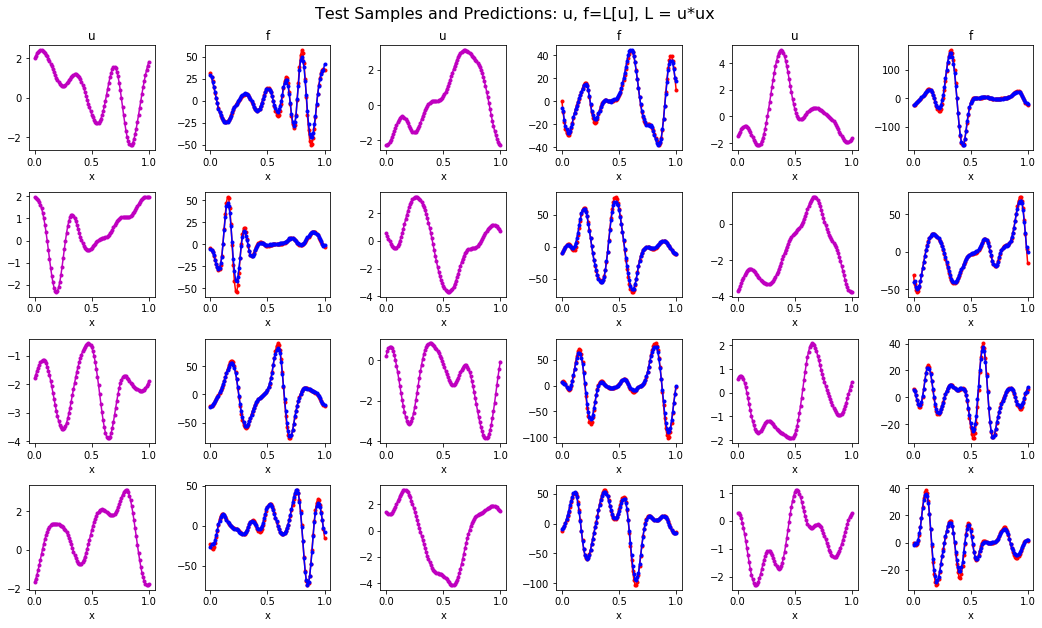

In [14]:
# collect a subset of the data to show and attach named labels
%matplotlib inline

num_prediction_samples = len(saved_test_input);
print("num_prediction_samples = " + str(num_prediction_samples));

#II = np.random.permutation(num_samples); # compute random collection of indices @optimize
II = np.arange(num_prediction_samples);

if flag_dataset == 'name-here' or 0 == 0:        
  u_list = []; f_list = []; f_pred_list = [];  
  for I in np.arange(0,min(num_prediction_samples,16)):        
    u_list.append(saved_test_input[II[I]].cpu());
    f_list.append(saved_test_target[II[I]].cpu());
    f_pred_list.append(saved_test_output_pred[II[I]].cpu());

# plot predictions against test data
gmlsnets.vis.plot_samples_u_f_fp_1d(u_list,f_list,f_pred_list,np_xj,np_xi,rows=4,cols=6,
                                    title="Test Samples and Predictions: u, f=L[u], L = %s"%op_type);

### Save Model

In [15]:
model_filename = '%s/model.ckpt'%base_dir;
print("model_filename = " + model_filename);
torch.save(model.state_dict(), model_filename);

model_filename = "%s/model_state.pickle"%base_dir;
print("model_filename = " + model_filename);
f = open(model_filename,'wb');
pickle.dump(model.state_dict(),f);
f.close();


model_filename = ./output/regression_diff_op_1d/diffOp1_Test1/model.ckpt
model_filename = ./output/regression_diff_op_1d/diffOp1_Test1/model_state.pickle


### Display the GMLS-Nets Learned Parameters

In [16]:
flag_run_cell = flag_print_model;

if flag_run_cell:
  print("-"*80)      
  print("model.parameters():");
  ll = model.parameters();
  for l in ll:
    print(l);    
  
if flag_run_cell:
  print("-"*80)        
  print("model.state_dict():");  
  print(model.state_dict());
  print("-"*80)    

### Done